In [1]:
%matplotlib inline

In [3]:
!pip install nilearn

     |████████████████████████████████| 3.0MB 8.1MB/s 


In [130]:
# Authors: Elvis Dhomatob, <elvis.dohmatob@inria.fr>, Apr. 2014
#          Virgile Fritsch, <virgile.fritsch@inria.fr>, Apr 2014
#          Gael Varoquaux, Apr 2014
#          Andres Hoyos-Idrobo, Apr 2017
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.image import get_data

n_subjects = 1000  # more subjects requires more memory

In [11]:
import torch
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
np.set_printoptions(precision=5, suppress=True)
import tensorflow as tf
import tensorflow_datasets as tfds

from typing import Any, Generator, Mapping, Tuple
!pip install -q git+git://github.com/deepmind/optax.git
!pip install -q git+https://github.com/deepmind/dm-haiku
from absl import app
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
from optax._src import transform
from jax import jit, grad, vmap
from jax.tree_util import tree_structure

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from matplotlib.pyplot import figure


     |████████████████████████████████| 51kB 3.6MB/s 


In [172]:
from nilearn.image import index_img, smooth_img
from torchvision import transforms, utils
import pickle 
import torch
from torch.utils.data import Dataset, DataLoader
from nilearn.masking import apply_mask

import haiku as hk

class mriDatasetAllSubjects(Dataset):
    """MRI dataset when all subjects data is mixed."""

    def __init__(self, root_dir, files_paths,labels,format, mask,transform=None):
        # event_file could be added when real data is available.
        # add this argument later: tsv_file
        """
        Args:
            files_paths (string): Path to the (f]mri) file (nifti or npy).
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample, i.e. flattening and subsampling.
        """
        self.root_dir = root_dir
        self.mask=mask

        if format is 'nifti':
            self.number_of_subjects = len(files_paths)
            self.labels = labels

            # list of NiftiImage objects for different subjects, i.e., if there are "two"
            # subjects, then X contains "two" 4-D images of shape (x_dim,y_dim,z_dim,time)
            X = []

            # list of events
            Y = []

            # This loop goes over the nifti images of the subjects
            for index, image_path in enumerate(files_paths):
                # load image and remove nan and inf values.
                # applying smooth_img to an image with fwhm=None simply cleans up
                # non-finite values but otherwise doesn't modify the image.
                self.path = os.path.join(self.root_dir, image_path)
                image = smooth_img(self.path, fwhm=None)
                #image = apply_mask(self.path, self.mask)
                X.append(image)
            
            self.subject_frames = np.array(X)
                                 
            # self.subject_frames = np.array(
            #                     [X[i].get_fdata() for i in range(self.number_of_subjects)])

        else:
            print("Broken for now.")
            # self.labels = list_of_labels
            #
            # self.path = os.path.join(self.root_dir, files_paths)
            #
            # image = np.load(self.path, encoding='bytes')
            # #image = np.reshape(image, (images.shape[1], images.shape[2], images.shape[3], images.shape[0]))
            #
            # self.subject_frames = images

        self.transform = transform

    def __len__(self):
        return (self.subject_frames).shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        print(self.suject_frames.shape)

        sample = self.subject_frames[idx, :, :, :]

        if self.transform:
            sample = self.transform(sample)

        return sample, self.labels[idx]


# In case we wanted to do experiments with ILC intra subjects
class mriDatasetSubject(Dataset):
    """MRI dataset for each subject."""

    def __init__(self, root_dir, mri_paths,ages,list_of_partitions,format,transform=None):
        # event_file could be added when real data is available.
        # add this argument later: tsv_file
        """
        Args:
            file_path (string): Path to the (fmri) file (nifti or npy).
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample, i.e. flattening and subsampling.
        """

        self.root_dir = root_dir
        self.mri_paths = mri_paths
        self.ages = ages
        self.path = os.path.join(self.root_dir, self.mri_paths)

        if format is 'nifti':
            self.subject_frames = smooth_img(self.path, fwhm=None).get_fdata()
            self.subject_frames = self.subject_frames[:, :, :, list_IDs]

        else:

            images = np.load(self.path, encoding='bytes')
            images = images[list_IDs, :, :, :]
            images = np.reshape(images, (images.shape[1], images.shape[2], images.shape[3], images.shape[0]))
            self.subject_frames = images

        self.transform = transform

    def __len__(self):
        return (self.subject_frames).shape[3]

    def __getitem__(self, idx):

        sample = self.subject_frames[:, :, :, idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, self.labels[idx]


class Flatten(object):
    """flatten the 3D image of a timestep.

    Args:
    """

    def __init__(self):
        pass

    def __call__(self, sample):

        dim_x = sample.shape[0]
        dim_y = sample.shape[1]
        dim_z = sample.shape[2]

        sample = sample.reshape(dim_x*dim_y,dim_z)
        sample = sample.reshape(sample.shape[0]*dim_z)
        return sample

class Subsample(object):
    """subsample the 3D image of a timestep.

    Args:
    """

    def __init__(self, subsample_rate_x,subsample_rate_y,subsample_rate_z):
        self.rate_x = subsample_rate_x
        self.rate_y = subsample_rate_y
        self.rate_z = subsample_rate_z

    def __call__(self, sample):

        dim_x = sample.shape[0]
        dim_y = sample.shape[1]
        dim_z = sample.shape[2]

        indexes_x = range(0,dim_x,self.rate_x)
        indexes_y = range(0,dim_y,self.rate_y)
        indexes_z = range(0,dim_z,self.rate_z)

        sample = sample[indexes_x,:,:]
        sample = sample[:,indexes_y,:]
        sample = sample[:,:,indexes_z]

        return sample


## Linear regression code

In [63]:
### JAX Code
class ANDMaskState(optax.OptState):
  """Stateless.""" # Following optax code style

def and_mask(agreement_threshold: float) -> optax.GradientTransformation:
  def init_fn(_):
    # Required by optax
    return ANDMaskState()

  def update_fn(updates, opt_state, params=None):

    def and_mask(update):
      # Compute the masked gradients for a single parameter tensor
      mask = jnp.abs(jnp.mean(jnp.sign(update), 0)) >= agreement_threshold
      mask = mask.astype(jnp.float32)
      avg_update = jnp.mean(update, 0)
      mask_t = mask.sum() / mask.size
      update = mask * avg_update * (1. / (1e-10 + mask_t))
      return update

    del params # Following optax code style
    
    # Compute the masked gradients over all parameters

    # jax.tree_map maps a function (lambda function in this case) over a pytree to produce a new pytree.
    updates = jax.tree_map(lambda x: and_mask(x), updates)
    return updates, opt_state

  return transform.GradientTransformation(init_fn, update_fn)


In [149]:

OptState = Any
Batch = Mapping[str, np.ndarray]

def linear_regression(train=None, test=None, adam_lr=0.3, agreement_threshold=0.0,
                               use_ilc=False, l1_coef=1e-4, l2_coef=1e-4,
                               epochs=1001, Verbose=False, training=True, normalizer=255.):
  
    training_loss = []
    testing_loss = []

    def net_fn(batch) -> jnp.ndarray:
        x = jnp.array(batch, jnp.float32) / normalizer
        mlp = hk.Sequential([
            hk.Flatten(),
            hk.Linear(1, with_bias=True)
        ])
        return mlp(x)

    

    # Make the network and optimiser.
    net = hk.without_apply_rng(hk.transform(net_fn))
        
    # Training loss (cross-entropy).
    def loss(params: hk.Params, batch, label) -> jnp.ndarray:
        """Compute the loss of the network, including L2."""
        logits = net.apply(params, batch)
        msl = 0.5 * jnp.sum(jnp.power(logits - label,2)) / batch.shape[0]

        return msl 

        
    # Regularization loss (L1,L2).
    def regularization_loss(params: hk.Params) -> jnp.ndarray:
        """Compute the regularization loss of the network, applied after ILC."""

        # L1 Loss
        sum_in_layer = lambda p: jnp.sum(jnp.abs(p))
        sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
        l1_loss = sum(sum_p_layers)

        # L2 Loss
        l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

        return l2_coef * l2_loss + l1_coef * l1_loss

    @jax.jit
    def gradient_per_sample(params, batch, label):
        batch, label = jnp.expand_dims(batch,1), jnp.expand_dims(label,1)
        return vmap(grad(loss), in_axes=(None, 0, 0))(params, batch, label)

    gradient = jax.jit(grad(loss))
    gradient_reg = jax.jit(grad(regularization_loss))

    @jax.jit
    def update(
        params: hk.Params,
        opt_state: OptState,
        batch, label, agreement
        ) -> Tuple[hk.Params, OptState]:
        """Learning rule (stochastic gradient descent)."""
        # grads_masked = (gradient_per_sample if use_ilc else gradient)(params, batch, label) # (gradient_per_sample)(params, batch, label)
        # sum_grad_masked_regularized = jax.tree_multimap(lambda x,y:x+y,grads_masked,gradient_reg(params))
        # grads = sum_grad_masked_regularized
        # updates, opt_state = opt.update(grads, opt_state)
        # new_params = optax.apply_updates(params, updates)

        # grads = gradient(params, batch, label)
        grads_samples = gradient_per_sample(params, batch, label)
        ANDmask = and_mask(agreement)

        masked_grads,_ = ANDmask.update(grads_samples, opt_state)
        reg_grads = gradient_reg(params)

        sum_grad_masked_regularized = jax.tree_multimap(lambda x,y:x+y,masked_grads,reg_grads)
 
        updates,_ = opt.update(sum_grad_masked_regularized, opt_state)

        new_params = optax.apply_updates(params, updates)

        return new_params, opt_state
        
    # We maintain avg_params, the exponential moving average of the "live" params.
    # avg_params is used only for evaluation.
    # For more, see: https://doi.org/10.1137/0330046
    @jax.jit
    def ema_update(
        avg_params: hk.Params,
        new_params: hk.Params,
        epsilon: float = 0.01,
    ) -> hk.Params:
        return jax.tree_multimap(lambda p1, p2: (1 - epsilon) * p1 + epsilon * p2,
                                avg_params, new_params)
    
    if training is False:
        return net
    else:
        if(use_ilc):

            use_ilc = False

            # opt = optax.chain(and_mask(agreement_threshold) if use_ilc else optax.identity(),optax.adam(adam_lr))

            # schedule_fn = optax.exponential_decay(adam_lr, # Note the minus sign!
            # 1,
            # 0.9)
            # opt = optax.chain(optax.sgd(adam_lr), optax.scale_by_schedule(schedule_fn)) # Or Adam could be used
            opt = optax.chain(optax.adam(adam_lr)) # Or Adam could be used

            # Initialize network and optimiser; note we draw an input to get shapes.
            params = avg_params = net.init(jax.random.PRNGKey(42), next(iter(train))[0])
            opt_state = opt.init(params)

            # Train/eval loop. WITHOUT ILC
            print("Begin training with ILC")
            for step in range(np.int(.5*epochs)):
                if step % np.int(epochs/10) == 0:
                    # Periodically evaluate classification accuracy on train & test sets.
                    Batch = next(iter(train))
                    train_loss = loss(avg_params, jnp.array(Batch[0]), jnp.array(Batch[1]))
                    train_loss = jax.device_get(train_loss)
                    Batch = next(iter(test))
                    test_loss = loss(avg_params, jnp.array(Batch[0]), jnp.array(Batch[1]))
                    test_loss = jax.device_get(test_loss)
                    training_loss.append(train_loss)
                    testing_loss.append(test_loss)
                    if Verbose:
                        print(f"[ILC Off, Step {step}] Train loss/Test loss: "
                                f"{train_loss:.3f} / {test_loss:.3f}.")

                # Do SGD on a batch of training examples.
                Batch = next(iter(train))
                params, opt_state = update(params, opt_state, jnp.array(Batch[0]), jnp.array(Batch[1]), 0.)
                avg_params = ema_update(avg_params, params)
            

            use_ilc = True

            
            # Train/eval loop. WITH ILC
            for step in range(np.int(.5*epochs)):
                if step % np.int(epochs/10) == 0:
                    # Periodically evaluate classification accuracy on train & test sets.
                    Batch = next(iter(train))
                    train_loss = loss(avg_params, jnp.array(Batch[0]), jnp.array(Batch[1]))
                    train_loss = jax.device_get(train_loss)
                    Batch = next(iter(test))
                    test_loss = loss(avg_params, jnp.array(Batch[0]), jnp.array(Batch[1]))
                    test_loss = jax.device_get(test_loss)
                    training_loss.append(train_loss)
                    testing_loss.append(test_loss)
                    if Verbose:
                        print(f"[ILC On, Step {step}] Train loss/Test loss: "
                                f"{train_loss:.3f} / {test_loss:.3f}.")

                # Do SGD on a batch of training examples.
                Batch = next(iter(train))
                params, opt_state = update(params, opt_state, jnp.array(Batch[0]), jnp.array(Batch[1]), agreement_threshold)
                avg_params = ema_update(avg_params, params)
          

            return params, training_loss, testing_loss

        else:
                
            # schedule_fn = optax.exponential_decay(adam_lr, # Note the minus sign!
            # 1,
            # 0.9)
            # opt = optax.chain(optax.sgd(adam_lr), optax.scale_by_schedule(schedule_fn)) # Or Adam could be used
            opt = optax.chain(optax.adam(adam_lr))

            # Initialize network and optimiser; note we draw an input to get shapes.
            params = avg_params = net.init(jax.random.PRNGKey(42), next(iter(train))[0])
            opt_state = opt.init(params)

            # Train/eval loop. 
            print("Begin training without ILC")
            for step in range(np.int(epochs)):
                if step % np.int(epochs/10) == 0:
                    # Periodically evaluate classification accuracy on train & test sets.
                    Batch = next(iter(train))
                    train_loss = loss(avg_params, jnp.array(Batch[0]), jnp.array(Batch[1]))
                    train_loss = jax.device_get(train_loss)
                    Batch = next(iter(test))
                    test_loss = loss(avg_params, jnp.array(Batch[0]), jnp.array(Batch[1]))
                    test_loss = jax.device_get(test_loss)
                    training_loss.append(train_loss)
                    testing_loss.append(test_loss)
                    if Verbose:
                        print(f"[ADAM, Step {step}] Train loss/Test loss: "
                                f"{train_loss:.3f} / {test_loss:.3f}.")
                        
                # Do SGD on a batch of training examples.
                Batch = next(iter(train))
                params, opt_state = update(params, opt_state, jnp.array(Batch[0]), jnp.array(Batch[1]), 0.)
                avg_params = ema_update(avg_params, params)

            
            return params, training_loss, testing_loss

Load Oasis dataset
-------------------



In [131]:
oasis_dataset = datasets.fetch_oasis_vbm(n_subjects=n_subjects)
gray_matter_map_filenames = oasis_dataset.gray_matter_maps
age = oasis_dataset.ext_vars['age'].astype(float)

# Split data into training set and test set
from sklearn.model_selection import train_test_split
gm_imgs_train, gm_imgs_test, age_train, age_test = train_test_split(
    gray_matter_map_filenames, age, train_size=.6, random_state=0)

# print basic information on the dataset
print('First gray-matter anatomy image (3D) is located at: %s' %
      oasis_dataset.gray_matter_maps[0])  # 3D data
print('First white-matter anatomy image (3D) is located at: %s' %
      oasis_dataset.white_matter_maps[0])  # 3D data

First gray-matter anatomy image (3D) is located at: /root/nilearn_data/oasis1/OAS1_0001_MR1/mwrc1OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz
First white-matter anatomy image (3D) is located at: /root/nilearn_data/oasis1/OAS1_0001_MR1/mwrc2OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz


/usr/local/lib/python3.6/dist-packages/nilearn/datasets/struct.py:317: UserWarning: Only 403 subjects are available in the DARTEL-normalized version of the dataset. All of them will be used instead of the wanted 1000
  % n_subjects)
/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Preprocess data
----------------



In [144]:
from nilearn.masking import apply_mask

nifti_masker = NiftiMasker(
    standardize=True,
    smoothing_fwhm=2,
    memory='nilearn_cache')  # cache options

gm_maps_masked_train = nifti_masker.fit_transform(gm_imgs_train)
gm_maps_masked_test = nifti_masker.fit_transform(gm_imgs_test)

# The features with too low between-subject variance are removed using
# :class:`sklearn.feature_selection.VarianceThreshold`.
from sklearn.feature_selection import VarianceThreshold
variance_threshold = VarianceThreshold(threshold=.01)
gm_maps_thresholded_trained = variance_threshold.fit_transform(gm_maps_masked_train)
gm_maps_masked_trained = variance_threshold.inverse_transform(gm_maps_thresholded_trained)

gm_maps_thresholded_test = variance_threshold.fit_transform(gm_maps_masked_test)
gm_maps_masked_test = variance_threshold.inverse_transform(gm_maps_thresholded_test)
# Then we convert the data back to the mask image in order to use it for
# decoding process
mask = nifti_masker.inverse_transform(variance_threshold.get_support())


## Data Loader

In [ ]:
import os
batch_size = 32
train = mriDatasetAllSubjects('', gm_imgs_train,age_train,format='nifti',mask=mask, transform=Subsample(2,2,2))
train_generator = DataLoader(train, batch_size=batch_size,shuffle=False,drop_last=False)
print(train_generator)
Batch = next(iter(train_generator))
print(Batch[0].shape,Batch[1])

test = mriDatasetAllSubjects('', gm_imgs_test,age_test,format='nifti', mask=mask,transform=Subsample(2,2,2))
test_generator = DataLoader(test, batch_size=batch_size,shuffle=False,drop_last=False)


In [125]:
results = []
nepochs=400
l2_ilc = 1e-4
l1_ilc = 1e-4
agreement_threshold=0.4
ilc_start_epoch = .5

OptState = Any
Batch = Mapping[str, np.ndarray]


params, sgd_train_loss, sgd_test_loss = linear_regression(train=train_generator, test=test_generator, adam_lr=0.3, agreement_threshold=0,
                                                        use_ilc=False, l1_coef=l1_ilc, l2_coef=l2_ilc,
                                                        epochs=nepochs, Verbose=True, training=True, normalizer=1.)
[results.append({'Epoch':i,'Method': 'SGD', 'Loss': sgd_train_loss[i],'Set':'Train'}) for i in range(len(sgd_train_loss))]
[results.append({'Epoch':i,'Method': 'SGD', 'Loss': sgd_test_loss[i],'Set':'Test'}) for i in range(len(sgd_test_loss))]

params, sgd_ilc_train_loss, sgd_ilc_test_loss = linear_regression(train=train_generator, test=test_generator, adam_lr=0.3, agreement_threshold=agreement_threshold,
                                                        use_ilc=True, l1_coef=l1_ilc, l2_coef=l2_ilc,
                                                        epochs=nepochs, Verbose=True, training=True, normalizer=1.)
[results.append({'Epoch':i,'Method': 'SGD-ILC', 'Loss': sgd_ilc_train_loss[i],'Set':'Train'}) for i in range(len(sgd_ilc_train_loss))]
[results.append({'Epoch':i,'Method': 'SGD-ILC', 'Loss': sgd_ilc_test_loss[i],'Set':'Test'}) for i in range(len(sgd_ilc_test_loss))]


Begin training without ILC
[ADAM, Step 0] Train loss/Test loss: 52081.441 / 46650.129.
[ADAM, Step 40] Train loss/Test loss: 2645857.000 / 2879109.000.
[ADAM, Step 80] Train loss/Test loss: 8114253.000 / 8746931.000.
[ADAM, Step 120] Train loss/Test loss: 13443176.000 / 14450345.000.
[ADAM, Step 160] Train loss/Test loss: 17755762.000 / 19061466.000.
[ADAM, Step 200] Train loss/Test loss: 20975354.000 / 22502272.000.
[ADAM, Step 240] Train loss/Test loss: 23278916.000 / 24963418.000.
[ADAM, Step 280] Train loss/Test loss: 24886950.000 / 26681168.000.
[ADAM, Step 320] Train loss/Test loss: 25992668.000 / 27862226.000.
[ADAM, Step 360] Train loss/Test loss: 26745780.000 / 28666584.000.
Begin training with ILC
[ILC Off, Step 0] Train loss/Test loss: 52081.441 / 46650.129.
[ILC Off, Step 40] Train loss/Test loss: 2645857.000 / 2879109.000.
[ILC Off, Step 80] Train loss/Test loss: 8114253.000 / 8746931.000.
[ILC Off, Step 120] Train loss/Test loss: 13443176.000 / 14450345.000.
[ILC Off, Ste

[None, None, None, None, None, None, None, None, None, None]

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_results(df,title):
    sns.lineplot(x='Epoch',y='Loss',hue='Method',style='Set',data=df)
    plt.axvline(ilc_start_epoch*df.Epoch.max(),0,1,color='grey')
    plt.title(title)
    



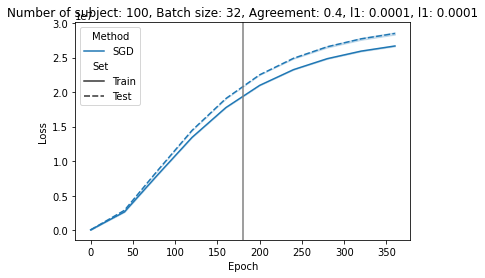

In [124]:
%matplotlib inline

import pandas as pd
df = pd.DataFrame(results)
df.Loss = df.Loss.astype('float')
df.Epoch = nepochs*df.Epoch/10

plot_results(df,f"Number of subject: {n_subjects}, Batch size: {batch_size}, Agreement: {agreement_threshold}, l1: {l1_ilc}, l1: {l2_ilc}")

Prediction pipeline with ANOVA and SVR using
:class:`nilearn.decoding.DecoderRegressor` Object



In [7]:
# In nilearn we can benefit from the built-in DecoderRegressor object to
# do ANOVA with SVR instead of manually defining the whole pipeline.
# This estimator also uses Cross Validation to select best models and ensemble
# them. Furthermore, you can pass n_jobs=<some_high_value> to the
# DecoderRegressor class to take advantage of a multi-core system.
# To save time (because these are anat images with many voxels), we include
# only the 1-percent voxels most correlated with the age variable to fit. We
# also want to set mask hyperparameter to be the mask we just obtained above.

from nilearn.decoding import DecoderRegressor
decoder = DecoderRegressor(estimator='svr', mask=mask,
                           scoring='neg_mean_absolute_error',
                           screening_percentile=1,
                           n_jobs=1)
# Fit and predict with the decoder
decoder.fit(gm_imgs_train, age_train)

# Sort test data for better visualization (trend, etc.)
perm = np.argsort(age_test)[::-1]
age_test = age_test[perm]
gm_imgs_test = np.array(gm_imgs_test)[perm]
age_pred = decoder.predict(gm_imgs_test)

prediction_score = -np.mean(decoder.cv_scores_['beta'])

print("=== DECODER ===")
print("explained variance for the cross-validation: %f" % prediction_score)
print("")

=== DECODER ===
explained variance for the cross-validation: 10.670598



Visualization
--------------



/usr/local/lib/python3.6/dist-packages/nilearn/plotting/displays.py:1609: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])


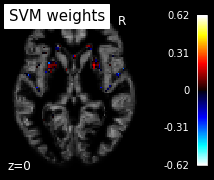

In [8]:
weight_img = decoder.coef_img_['beta']

# Create the figure
from nilearn.plotting import plot_stat_map, show
bg_filename = gray_matter_map_filenames[0]
z_slice = 0
display = plot_stat_map(weight_img, bg_img=bg_filename,
                        display_mode='z', cut_coords=[z_slice])
display.title("SVM weights")
show()

Visualize the quality of predictions
-------------------------------------



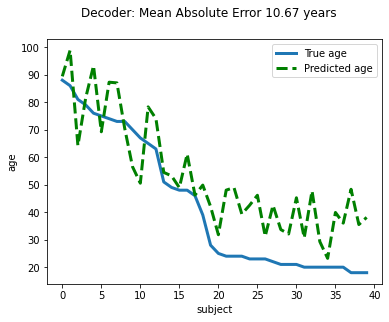

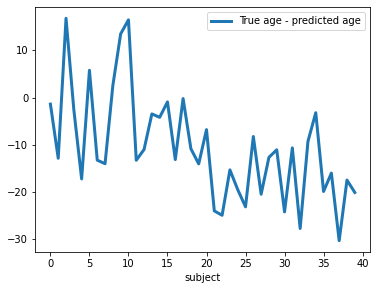

In [9]:
plt.figure(figsize=(6, 4.5))
plt.suptitle("Decoder: Mean Absolute Error %.2f years" % prediction_score)
linewidth = 3
plt.plot(age_test, label="True age", linewidth=linewidth)
plt.plot(age_pred, '--', c="g", label="Predicted age", linewidth=linewidth)
plt.ylabel("age")
plt.xlabel("subject")
plt.legend(loc="best")
plt.figure(figsize=(6, 4.5))
plt.plot(age_test - age_pred, label="True age - predicted age",
         linewidth=linewidth)
plt.xlabel("subject")
plt.legend(loc="best")

Inference with massively univariate model
-----------------------------------------



Massively univariate model


/usr/local/lib/python3.6/dist-packages/nilearn/plotting/displays.py:1609: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])



1975 detections


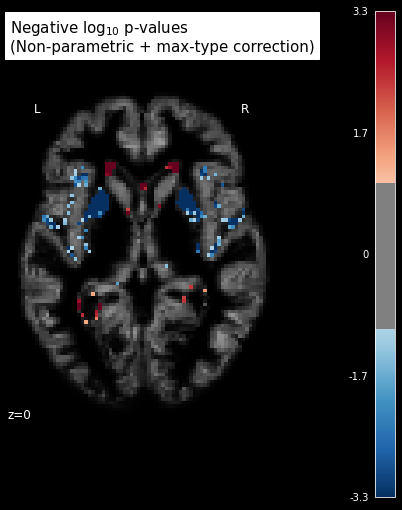

In [10]:
print("Massively univariate model")

gm_maps_masked = NiftiMasker().fit_transform(gray_matter_map_filenames)
data = variance_threshold.fit_transform(gm_maps_masked)

# Statistical inference
from nilearn.mass_univariate import permuted_ols
neg_log_pvals, t_scores_original_data, _ = permuted_ols(
    age, data,  # + intercept as a covariate by default
    n_perm=2000,  # 1,000 in the interest of time; 10000 would be better
    n_jobs=1)  # can be changed to use more CPUs
signed_neg_log_pvals = neg_log_pvals * np.sign(t_scores_original_data)
signed_neg_log_pvals_unmasked = nifti_masker.inverse_transform(
    variance_threshold.inverse_transform(signed_neg_log_pvals))

# Show results
threshold = -np.log10(0.1)  # 10% corrected

fig = plt.figure(figsize=(5.5, 7.5), facecolor='k')

display = plot_stat_map(signed_neg_log_pvals_unmasked, bg_img=bg_filename,
                        threshold=threshold, cmap=plt.cm.RdBu_r,
                        display_mode='z', cut_coords=[z_slice],
                        figure=fig)
title = ('Negative $\\log_{10}$ p-values'
         '\n(Non-parametric + max-type correction)')
display.title(title, y=1.2)

n_detections = (get_data(signed_neg_log_pvals_unmasked) > threshold).sum()
print('\n%d detections' % n_detections)

show()